In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

def preprocess_data(data_path, test_size=0.2, downsample_factor=10):
    """
    Preprocess and downsample the climate dataset.
    
    Args:
        data_path (str): Path to the climate dataset.
        test_size (float): Proportion of data to use for testing.
        downsample_factor (int): Factor to reduce the training data size by.

    Returns:
        X_train, X_test, y_train, y_test: Split and downsampled data for model training.
        scaler: The scaler used for normalization.
    """
    data = pd.read_csv(data_path)
    
    target_variable = "T (degC)" 
    y_data = data[target_variable].values.reshape(-1, 1)

    scaler = StandardScaler()
    scaled_y = scaler.fit_transform(y_data).flatten()

    # Downsample data to speed up training
    scaled_y = scaled_y[::downsample_factor]
    
    # Create lagged features for XGBoost input
    X = []
    y = []
    lag_steps = 5 
    for i in range(lag_steps, len(scaled_y)):
        # Create lagged features for sequence modeling
        X.append(scaled_y[i - lag_steps:i])
        y.append(scaled_y[i])

    X = np.array(X)
    y = np.array(y)

    split_idx = int(len(y) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(
        f"Preprocessing complete. Training set size: {len(X_train)}, Test set size: {len(X_test)}"
    )
    return X_train, X_test, y_train, y_test, scaler

In [44]:
def train_xgboost_model(X_train, y_train):
    """
    Train the XGBoost model using provided training data.

    Args:
        X_train (array-like): Training features.
        y_train (array-like): Training targets.

    Returns:
        Trained XGBoost model.
    """
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
    )
    model.fit(X_train, y_train)
    return model

In [45]:
def forecast_xgboost(model, X_test):
    """
    Make predictions on the test data using the trained XGBoost model.

    Args:
        model: Trained XGBoost model.
        X_test (array-like): Test features.

    Returns:
        predictions: Model predictions.
    """
    predictions = model.predict(X_test)
    return predictions

In [46]:
def evaluate_model(y_test, predictions):
    """
    Compute and print the RMSE value for evaluation.

    Args:
        y_test (array-like): True target values from the test set.
        predictions (array-like): Predicted values from the model.
    """
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"RMSE: {rmse:.4f}")

In [47]:
def plot_results(y_test, predictions):
    """
    Visualize the actual vs. predicted forecast results.

    Args:
        y_test (array-like): Actual test data values.
        predictions (array-like): Model predictions.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label="Actual", color="blue")
    plt.plot(predictions, label="Predicted", color="orange")
    plt.legend()
    plt.xlabel("Time Index")
    plt.ylabel("Scaled Temperature")
    plt.title("Actual vs Predicted (XGBoost)")
    plt.show()

In [62]:
def feature_importance(data, model):
    """
    PLot feature importance graph

    Args:
        data: Path to the dataset
        model: Trained XGBoost model
    """
    df = pd.read_csv(data)
    feature_names = df.columns  

    # Extract feature importances
    importance = model.get_booster().get_score(importance_type='weight')

    # Map feature indices to names
    importance_df = pd.DataFrame({
        'Feature': [feature_names[int(feat[1:])] for feat in importance.keys()],
        'Importance': list(importance.values())
    })

    # Sort by importance in descending order
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Filter to show all significant features
    threshold = 1 
    significant_features = importance_df[importance_df["Importance"] >= threshold]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(significant_features['Feature'], significant_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance for XGBoost')
    plt.gca().invert_yaxis()  # To show the most important feature on top
    plt.show()

Preprocessing complete. Training set size: 33640, Test set size: 8411
RMSE: 0.1414


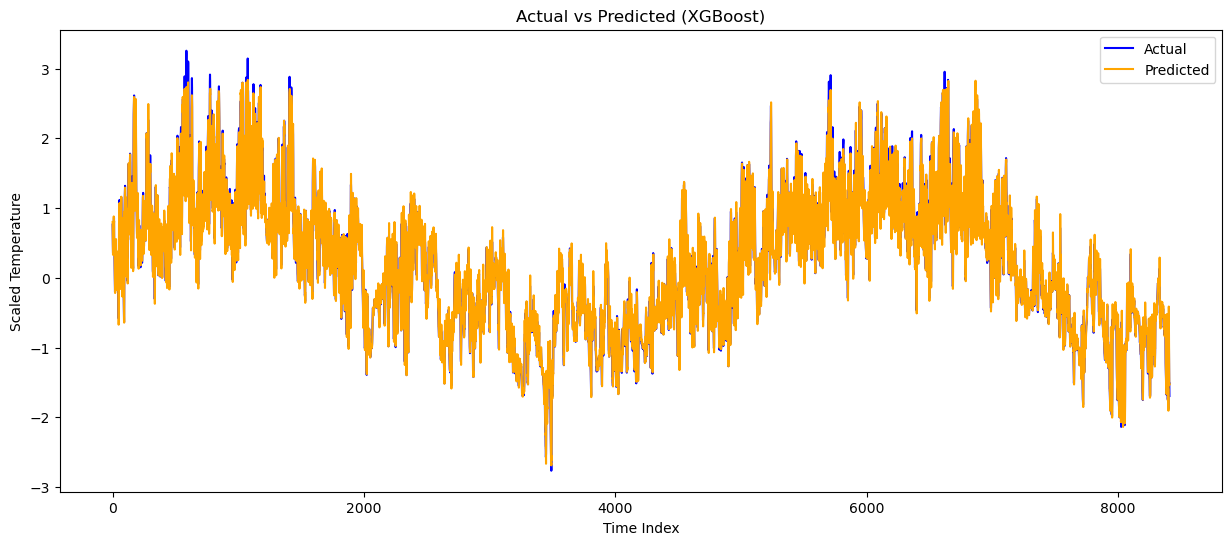

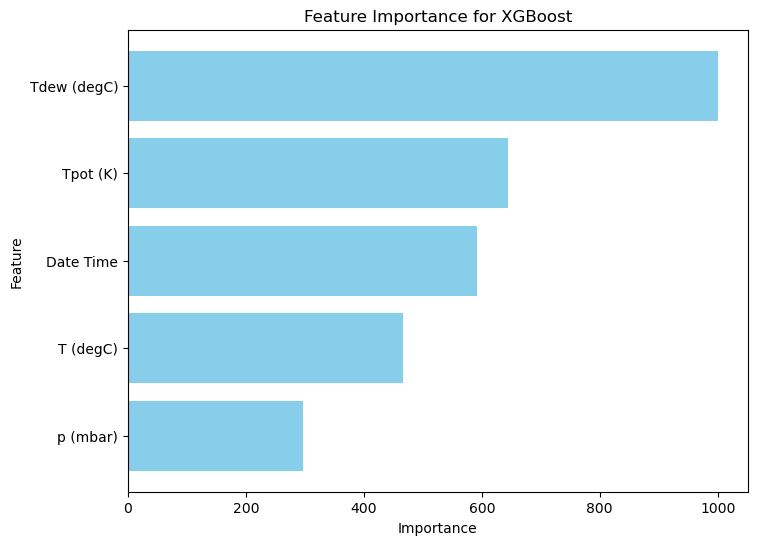

XGBoost Hyperparameters:
           Parameter            Value
Number of Estimators              100
       Learning Rate              0.1
           Max Depth                6
           Subsample              0.8
   Colsample by Tree              0.8
           Objective reg:squarederror


In [67]:
def main():
    data_path = "jena_climate_2009_2016.csv"
    
    # Preprocess the data
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data_path, downsample_factor=10)
    
    # Train the XGBoost model
    model = train_xgboost_model(X_train, y_train)
    
    # Forecast predictions
    predictions = forecast_xgboost(model, X_test)

    # Evaluate the model
    evaluate_model(y_test, predictions)

    # Visualize the results
    plot_results(y_test, predictions)

    #Plot feature importance values
    feature_importance(data_path, model)

    xgboost_hyperparameters = {
    "Parameter": [
        "Number of Estimators", "Learning Rate", "Max Depth", 
        "Subsample", "Colsample by Tree", "Objective"
    ],
    "Value": [
        100, 0.1, 6, 0.8, 0.8, "reg:squarederror"
    ]
    }

    xgboost_table = pd.DataFrame(xgboost_hyperparameters)
    print("XGBoost Hyperparameters:")
    print(xgboost_table.to_string(index=False))

if __name__ == "__main__":
    main()